In [1]:
import numpy as np
import matplotlib.pyplot as plt
from readTabTxtFile import *
import os
import pickle
import copy
from ssm.util import random_rotation, find_permutation
import seaborn as sns
import ssm

In [2]:
directory = "/media/watson/UbuntuHDD/feng_Xin/Xin/Miniscope/newcohort_03242024/reward_seeking/7277102232024/poke_lick_sham_day21/16_24_44"
cellTracesFile = "cellTraces_norm.txt"
validIdFile = "validIdx.txt"
cellTracesFile = "cellTraces_norm.txt"
frameCorrectionFile = "frame_correction_pos.pickle"

color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,marker='o',
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

In [3]:
# def factorial(n):

#     if n <= 0:
#         return 1
#     else:
#         return factorial(n-1) * n
# x = np.arange(0,3,0.5)
# y = np.zeros((len(x)))

# for x_i,a_i in zip(x,range(len(x))):
#     y[a_i] = factorial(x_i)


In [4]:
with open(directory + os.sep + frameCorrectionFile,'rb') as f:
    frame_correction = pickle.load(f)
with open(directory + os.sep + cellTracesFile, "r", newline="\n") as readFile:
    data_reader = readFile.readlines()

valid_idx = readTabTxtFile(directory + os.sep + validIdFile, 'int')

ca_traces = []
for i in valid_idx:
    ca_trace = [float(k) for k in data_reader[i].strip().split("\t")]
    if frame_correction:
        ca_trace_corrected = ca_trace[0:frame_correction[0]+1]+ [float('NaN')]* frame_correction[1] + ca_trace[frame_correction[0]+1:-1]
    else:
        ca_trace_corrected = ca_trace
    ca_traces.append(ca_trace_corrected)
y = np.transpose(np.array(ca_traces))

In [5]:
def findClosestTimeIndex(t,tSeries):
    tDiff = [abs(t-i) for i in tSeries]
    nd_tDiff = np.array(tDiff)
    pos = np.argmin(nd_tDiff)
    return pos
def findAfterClosestIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT>=0]
    if tDiff:
        nd_tDiff = np.array(tDiff)
        lick_pos = np.argmin(nd_tDiff[:,0])
        pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    else:
        print('tDiff is empty!')
        pos = []
    return pos

def findBeforeClosestIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT<=0]
    nd_tDiff = np.array(tDiff)
    lick_pos = np.argmax(nd_tDiff[:,0])
    pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    return pos
pumpTime = readTabTxtFile(directory+os.sep+"stim2.txt", 'float')
caTime = readTabTxtFile(directory+os.sep+"stim4.txt", 'float')

pumpInd = []
for i in range(len(pumpTime)):
    pump_temp = findClosestTimeIndex(pumpTime[i],caTime)
    if pump_temp:
        pumpInd.append(pump_temp)

pokeTime = readTabTxtFile(directory+os.sep+"stim0.txt", 'float')
pokeInd = []
for i in range(len(pokeTime)):
    poke_temp = findClosestTimeIndex(pokeTime[i],caTime)
    if poke_temp:
        pokeInd.append(poke_temp)

 
lickTime = readTabTxtFile(directory+os.sep+"stim3.txt", 'float')
lickInd = []
for i in range(len(pumpTime)):
    pre_temp = findBeforeClosestIndex(pokeTime, pumpTime[i], caTime) 
    ref_temp = findAfterClosestIndex(lickTime, caTime[pre_temp], caTime) 
    if ref_temp:
        lickInd.append(ref_temp)

lickInd = np.array(lickInd)
pokeInd = np.array(pokeInd)
pumpInd = np.array(pumpInd)

In [6]:
D_obs = 50
D_latent = 2
K = 4

In [7]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)
q_elbos_lem, q_lem = rslds.fit(y, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=400, alpha=0.0)


  0%|          | 0/400 [00:00<?, ?it/s]

In [8]:
xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, y)))
zhat_lem = rslds.most_likely_states(xhat_lem, y)

# store rslds
rslds_lem = copy.deepcopy(rslds)

In [ ]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)

q_elbos_bbvi, q_bbvi = rslds.fit(y, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=10000)

In [ ]:
# Get the posterior mean of the continuous states
xhat_bbvi = q_bbvi.mean[0]

# Find the permutation that matches the true and inferred states
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_bbvi, y)))
zhat_bbvi = rslds.most_likely_states(xhat_bbvi, y)

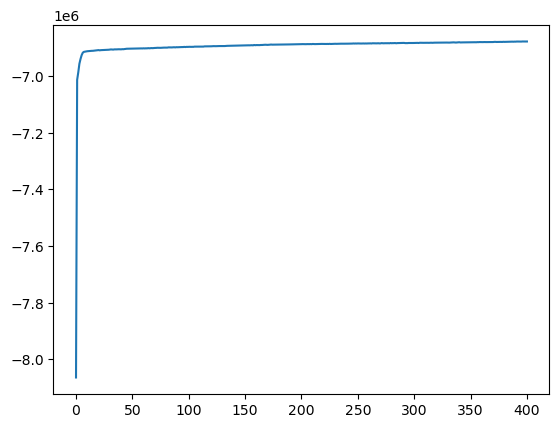

In [9]:
plt.figure()
plt.plot(q_elbos_lem, label="LEM")

In [10]:
print(xhat_bbvi[0,:])
print(zhat_bbvi.shape)
print(len(pumpInd))
print(lickInd[-1])
print(pokeInd[-3])
print(zhat_bbvi[lickInd[0:-1]])
np.set_printoptions(threshold=np.inf)

print(np.where(zhat_lem==0)[0].shape)


NameError: name 'xhat_bbvi' is not defined

In [11]:
xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, y)))
zhat_lem = rslds.most_likely_states(xhat_lem, y)
print(zhat_lem.shape)
print(xhat_lem.shape)

(42743,)
(42743, 2)


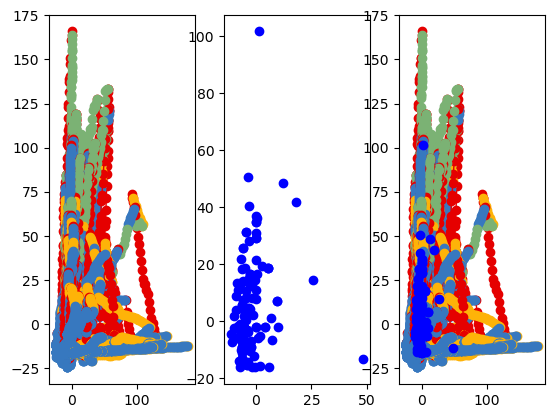

In [13]:
plt.figure()
ax1 = plt.subplot(131)
plot_trajectory(zhat_lem, xhat_lem,ax=ax1)
# for pump triggers
# ax2 = plt.subplot(132)
# ax2.plot(xhat_bbvi[pumpInd[0:-1],0],xhat_bbvi[pumpInd[0:-1],1],'bo')
# ax3 = plt.subplot(133)
# plot_trajectory(zhat_bbvi, xhat_bbvi,ax=ax3)
# ax3.plot(xhat_bbvi[pumpInd[0:-1],0],xhat_bbvi[pumpInd[0:-1],1],'bo')

# for pokes
ax2 = plt.subplot(132)
# ax2.plot(xhat_lem[pokeInd[0:-2],0],xhat_lem[pokeInd[0:-2],1],'bo')
# ax3 = plt.subplot(133)
# plot_trajectory(zhat_lem, xhat_lem,ax=ax3)
# ax3.plot(xhat_lem[pokeInd[0:-2],0],xhat_lem[pokeInd[0:-2],1],'bo')


# for licks
ax2 = plt.subplot(132)
ax2.plot(xhat_lem[lickInd[0:-1],0],xhat_lem[lickInd[0:-1],1],'bo')
ax3 = plt.subplot(133)
plot_trajectory(zhat_lem, xhat_lem,ax=ax3)
ax3.plot(xhat_lem[lickInd[0:-1],0],xhat_lem[lickInd[0:-1],1],'bo')


AttributeError: 'RecurrentTransitions' object has no attribute 'r'

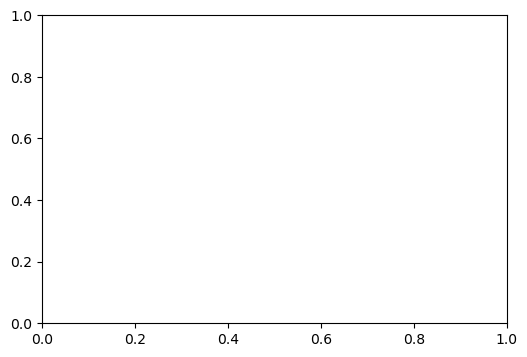

In [15]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, Laplace-EM")

In [16]:
rslds_lem.transitions.

AttributeError: 'RecurrentTransitions' object has no attribute 'r'